In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rqfactor
import talib
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
warnings.filterwarnings("ignore")
rqdatac.init()

Cannot initialize filter sz3: File not found


In [2]:
import pandas as pd
df_etf = pd.read_excel('../ETF0-ML/etf标的.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [3]:
symbol = df_etf.order_book_id.values.tolist()
start = "2020-01-01"
end = "2023-12-31"
frequency = "1d"

In [5]:
df_price_entry = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
df_price_entry

order_book_id,159507.XSHE,159611.XSHE,159619.XSHE,159766.XSHE,159825.XSHE,159852.XSHE,159869.XSHE,159870.XSHE,159928.XSHE,159930.XSHE,...,512660.XSHG,512800.XSHG,512880.XSHG,512980.XSHG,513050.XSHG,515030.XSHG,515790.XSHG,515880.XSHG,516110.XSHG,561320.XSHG
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7562,0.715,...,0.771,1.152,1.049,0.883,1.466,NaN,NaN,1.088,NaN,NaN
2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7520,0.726,...,0.784,1.153,1.045,0.886,1.479,NaN,NaN,1.094,NaN,NaN
2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7532,0.744,...,0.793,1.149,1.045,0.905,1.450,NaN,NaN,1.103,NaN,NaN
2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7700,0.738,...,0.794,1.153,1.053,0.933,1.474,NaN,NaN,1.109,NaN,NaN
2020-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7647,0.732,...,0.805,1.132,1.021,0.906,1.453,NaN,NaN,1.088,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,0.841,0.866,0.813,0.686,0.714,0.739,0.990,0.572,0.8300,1.254,...,0.946,1.034,0.885,0.707,0.923,1.144,0.834,1.002,1.004,0.829
2023-12-26,0.832,0.862,0.809,0.677,0.710,0.724,0.981,0.572,0.8250,1.238,...,0.936,1.030,0.874,0.699,0.921,1.136,0.834,0.979,0.994,0.821
2023-12-27,0.834,0.872,0.815,0.675,0.726,0.724,0.976,0.570,0.8300,1.260,...,0.935,1.035,0.882,0.691,0.929,1.129,0.829,0.985,0.995,0.818


In [12]:
data = df_price_entry.copy()
name_list = data.columns.values.tolist()
N = 20
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0

min_growth_etfs = data[['涨幅_'+v for v in name_list]].idxmin(axis=1, skipna=True)
data['信号'] = min_growth_etfs.str.replace('涨幅_', '')
data['信号'] = data['信号'].shift(1)
def calculate_strategy_return(row):
    if row['信号'] is not None:
        etf_return = row['日收益率_'+row['信号']] if pd.notna(row['日收益率_'+row['信号']]) else 0.0
    else:
        etf_return = 0.0
    return etf_return

data['轮动策略日收益率'] = data.apply(calculate_strategy_return, axis=1)
data.loc[data.index[0], '轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()


TypeError: can only concatenate str (not "float") to str

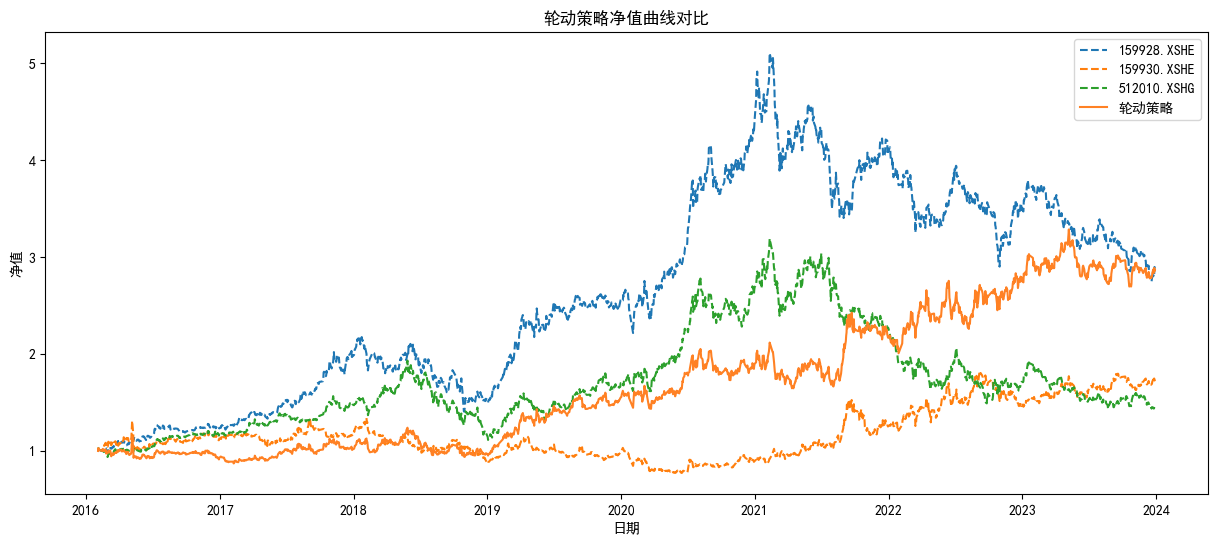

In [176]:
# 可选的ETF 时间长的ETf少

import matplotlib.pyplot as plt
# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

#### 测试动量和反转策略相关性 负相关 不work

In [167]:
a = data['轮动策略净值']

In [168]:
a = a.values
a

array([1.        , 1.00277393, 1.01386963, ..., 0.91357661, 0.92944519,
       0.93171213])

In [177]:
b = data['轮动策略净值'].values
b


array([1.        , 1.03046595, 1.0125448 , ..., 2.88845487, 2.8540685 ,
       2.87011547])

In [178]:
np.corrcoef(a,b)

array([[ 1.        , -0.72781291],
       [-0.72781291,  1.        ]])

#### 测试货币 债券ETF

In [180]:
import pandas as pd
df_etf = pd.read_excel('ETF_bond.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [id_convert(code) for code in etf_code]
df_price_bond = get_price(etf_code, start_date='20160101' ,end_date='20231231' , fields=['close'])
df_price_bond.head()

close
order_book_id date               
159001.XSHE   2016-01-04   99.992
              2016-01-05   99.999
              2016-01-06  100.001
              2016-01-07  100.000
              2016-01-08  100.001

In [181]:
data = df_price_bond.copy()
data = data.unstack(level = 0)
data.columns = data.columns.droplevel(0)
data = data.dropna(axis=1 , how='any')
data

order_book_id,159001.XSHE,159003.XSHE,159005.XSHE,511800.XSHG,511810.XSHG,511830.XSHG,511860.XSHG,511880.XSHG,511900.XSHG,511930.XSHG,511980.XSHG,511990.XSHG,511010.XSHG,511220.XSHG
date,,,,,,,,,,,,,,
2016-01-04,99.992,99.987,99.990,99.968,99.974,99.972,99.970,82.3373,99.979,99.978,99.960,99.975,109.505,7.2353
2016-01-05,99.999,99.999,100.002,99.976,99.981,99.980,99.978,82.3768,99.977,100.000,99.976,99.994,109.440,7.2346
2016-01-06,100.001,100.002,100.002,99.997,99.996,100.000,99.994,82.3842,99.995,99.995,99.992,100.006,109.475,7.2353
2016-01-07,100.000,99.999,100.000,100.000,99.998,100.000,99.998,82.3907,99.999,100.001,99.998,100.010,109.591,7.2349
2016-01-08,100.001,100.000,100.005,100.007,100.005,100.005,100.003,82.4121,100.004,100.008,100.003,100.024,109.850,7.2699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,100.000,99.997,99.999,99.996,99.997,99.992,99.998,100.0398,100.000,99.995,100.088,99.988,132.895,10.0460
2023-12-26,100.001,99.997,99.999,99.987,99.997,99.993,99.998,100.0388,99.999,99.995,100.201,99.987,132.997,10.0450
2023-12-27,100.000,99.990,99.999,99.996,99.996,99.994,99.998,100.0418,99.997,99.995,100.054,99.981,133.126,10.0510


In [182]:
name_list = data.columns.values.tolist()
N = 20
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
data = data.dropna()
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()


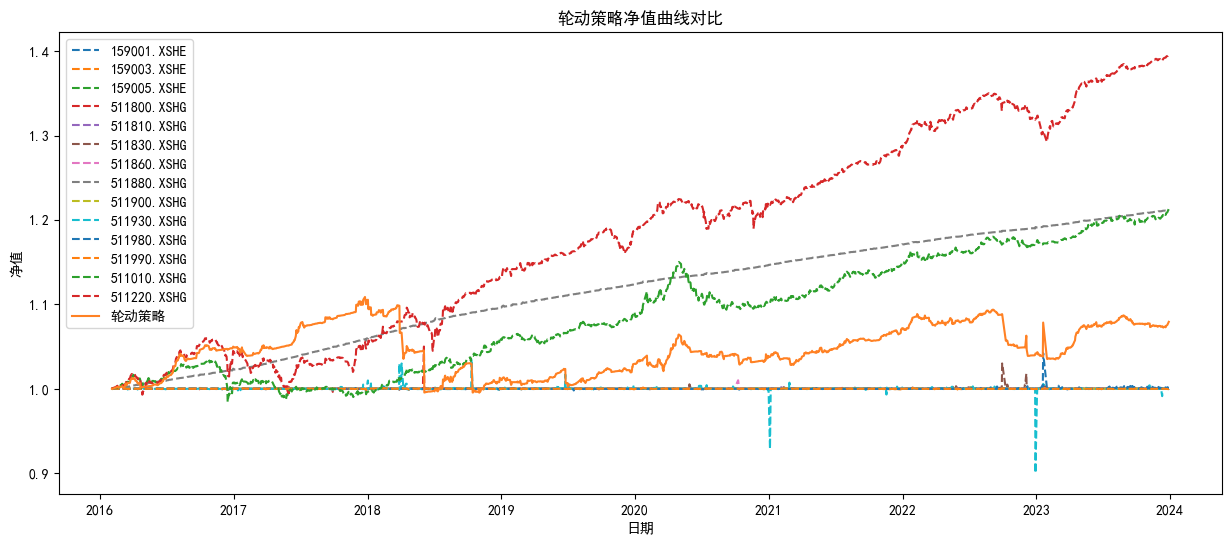

In [183]:
# 可选的ETF 时间长的ETf少

import matplotlib.pyplot as plt
# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

In [185]:
c = data['轮动策略净值'].values
len(c)

1923

In [186]:
np.corrcoef(b,c)

array([[1.       , 0.4339209],
       [0.4339209, 1.       ]])

* 改进 1：尝试使用wind 的行业指数

保持无交集且差异化的ETF列表

In [121]:
df_etf_code = pd.read_excel('ETF_industry.xlsx')
etf_code = df_etf_code.code.values.tolist()
etf_code_3 = [id_convert(code) for code in etf_code]

In [122]:
df_price_2 = get_price(etf_code_3, start_date='20160101' ,end_date='20231231' , fields=['close'])
df_price_2

close
order_book_id date             
159672.XSHE   2023-04-03  1.010
              2023-04-04  1.024
              2023-04-06  1.010
              2023-04-07  1.003
              2023-04-10  0.995
...                         ...
159546.XSHE   2023-12-25  0.975
              2023-12-26  0.954
              2023-12-27  0.960
              2023-12-28  0.979
              2023-12-29  0.990

[65806 rows x 1 columns]

In [156]:
def get_dynamic_list(index_list, start_dt, end_dt):
    inter_list = []
    coef_list = []
    sort_list = []
    total_close_list = []
    df = get_price(index_list, start_dt, end_dt, fields='close')
    df = df.unstack(level = 0)
    df.columns = df.columns.droplevel(0)
    df = df.dropna(axis=1 , how='any')
    for index in df.columns.values.tolist():
        close_list = df[index].values
        total_close_list.append(close_list)
    print(len(total_close_list))
    matrix = np.corrcoef(total_close_list)

    x=1    
    while x<=matrix.shape[0]:
        y=1
        while y<x:
            inter_list.append((index_list[x-1],index_list[y-1]))
            coef_list.append(matrix[x-1][y-1])
            y+=1
        x+=1
    df_coef = pd.DataFrame(columns=['inter_code','coefficient'])
    df_coef['inter_code'] = inter_list
    df_coef['coefficient'] = coef_list
    df_coef.sort_values(by='coefficient', ascending=True, inplace=True)
    for i in range(4):
        sort_list.append(df_coef.inter_code.tolist()[i][0])
        sort_list.append(df_coef.inter_code.tolist()[i][1])
    final_list = list(set(sort_list))
    return final_list

etf_list = etf_code_3
start_dt, end_dt = '2016-01-01', '2023-12-31'
updated_etf_code = get_dynamic_list(etf_list, start_dt, end_dt)

14


In [174]:
updated_etf_code

['159930.XSHE', '517380.XSHG', '517990.XSHG', '159887.XSHE', '159938.XSHE']

In [176]:
def get_matrix(index_list, start_dt, end_dt):
    total_close_list = []
    df = get_price(index_list, start_dt, end_dt, fields='close')
    df = df.unstack(level = 0)
    df.columns = df.columns.droplevel(0)
    df = df.dropna(axis=1 , how='any')
    for index in df.columns.values.tolist():
        close_list = df[index].values
        total_close_list.append(close_list)
    matrix = np.corrcoef(total_close_list)
    print(matrix)
get_matrix(updated_etf_code , start_dt='20160101',end_dt='20231231')

[[ 1.         -0.05044488]
 [-0.05044488  1.        ]]


In [167]:
df_price_updated = get_price(updated_etf_code, start_date='20160101' ,end_date='20231231' , fields=['close'])
df_price_updated

close
order_book_id date             
159930.XSHE   2016-01-04  0.912
              2016-01-05  0.890
              2016-01-06  0.899
              2016-01-07  0.899
              2016-01-08  0.865
...                         ...
159938.XSHE   2023-12-25  0.685
              2023-12-26  0.681
              2023-12-27  0.687
              2023-12-28  0.693
              2023-12-29  0.699

[5507 rows x 1 columns]

In [154]:
data_2= df_price_2.copy()
data_2 = data_2.unstack(level = 0)
data_2 = data_2.dropna(axis=1 , how='any')
data_2.columns = data_2.columns.droplevel(0)
data_2

order_book_id,159936.XSHE,159938.XSHE,159939.XSHE,159944.XSHE,159945.XSHE,159928.XSHE,159929.XSHE,159930.XSHE,512010.XSHG,512330.XSHG,512600.XSHG,510230.XSHG,510630.XSHG,510660.XSHG
date,,,,,,,,,,,,,,
2016-01-04,1.779,0.6840,0.6590,0.854,0.670,0.3520,1.496,0.912,0.3248,0.964,0.2854,0.8410,0.3645,1.564
2016-01-05,1.638,0.6700,0.6445,0.815,0.669,0.3475,1.464,0.890,0.3232,0.929,0.2728,0.8460,0.3660,1.555
2016-01-06,1.649,0.6715,0.6490,0.855,0.689,0.3500,1.485,0.899,0.3248,0.951,0.2822,0.8536,0.3705,1.577
2016-01-07,1.590,0.6335,0.5845,0.810,0.643,0.3465,1.404,0.899,0.3150,0.880,0.2814,0.8130,0.3558,1.488
2016-01-08,1.604,0.6405,0.5950,0.824,0.665,0.3302,1.408,0.865,0.3200,0.878,0.2692,0.8216,0.3520,1.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.540,0.6850,0.5090,0.851,1.038,0.8300,1.424,1.254,0.4040,0.831,0.7070,0.9290,0.9320,2.341
2023-12-26,1.527,0.6810,0.5010,0.850,1.028,0.8250,1.414,1.238,0.4010,0.813,0.7020,0.9250,0.9260,2.328
2023-12-27,1.532,0.6870,0.5050,0.852,1.044,0.8300,1.418,1.260,0.4030,0.824,0.7070,0.9270,0.9310,2.334


In [155]:
# 做动量策略 买入前 N 个交易日涨幅最大的 ETF
data = data_2.copy()
name_list = data.columns.values.tolist()
N = 20
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
data = data.dropna()
data[['涨幅_'+v for v in name_list]].head(10)

order_book_id,涨幅_159936.XSHE,涨幅_159938.XSHE,涨幅_159939.XSHE,涨幅_159944.XSHE,涨幅_159945.XSHE,涨幅_159928.XSHE,涨幅_159929.XSHE,涨幅_159930.XSHE,涨幅_512010.XSHG,涨幅_512330.XSHG,涨幅_512600.XSHG,涨幅_510230.XSHG,涨幅_510630.XSHG,涨幅_510660.XSHG
date,,,,,,,,,,,,,,
2016-02-02,-0.266442,-0.183480,-0.198786,-0.176815,-0.164179,-0.148295,-0.168449,-0.177632,-0.137931,-0.190871,-0.147863,-0.131391,-0.138546,-0.164322
2016-02-03,-0.188034,-0.166418,-0.173002,-0.158282,-0.170404,-0.151079,-0.151639,-0.189888,-0.136757,-0.155005,-0.110704,-0.144090,-0.143443,-0.158199
2016-02-04,-0.178290,-0.146687,-0.164099,-0.194152,-0.184325,-0.148571,-0.146801,-0.195773,-0.114840,-0.159832,-0.135365,-0.141401,-0.143590,-0.155992
2016-02-05,-0.159748,-0.100237,-0.083832,-0.146914,-0.121306,-0.137085,-0.099003,-0.186874,-0.103175,-0.097727,-0.132907,-0.102091,-0.110455,-0.106855
2016-02-15,-0.164589,-0.106167,-0.100000,-0.151699,-0.150376,-0.108116,-0.103693,-0.167630,-0.125000,-0.100228,-0.102526,-0.121470,-0.105114,-0.098649
2016-02-16,-0.071860,0.006780,0.003587,-0.149038,-0.109737,-0.080368,-0.013919,-0.106205,-0.065963,0.016010,-0.034348,-0.052907,-0.028529,-0.007215
2016-02-17,-0.040439,-0.012428,0.007993,-0.126829,-0.069841,-0.071385,0.018727,-0.082225,-0.067769,0.014670,-0.036519,-0.054835,-0.024865,-0.010776
2016-02-18,-0.015331,-0.007563,0.024434,-0.124239,-0.060510,-0.069581,0.020642,-0.061728,-0.081734,0.049305,-0.012698,-0.047509,-0.010067,0.011861
2016-02-19,-0.029696,-0.031071,-0.023973,-0.108209,-0.059486,-0.077299,-0.011312,-0.064198,-0.068197,0.001199,-0.028191,-0.059430,-0.028401,-0.015816


In [156]:
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['涨幅_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)

order_book_id,涨幅_159936.XSHE,涨幅_159938.XSHE,涨幅_159939.XSHE,涨幅_159944.XSHE,涨幅_159945.XSHE,涨幅_159928.XSHE,涨幅_159929.XSHE,涨幅_159930.XSHE,涨幅_512010.XSHG,涨幅_512330.XSHG,涨幅_512600.XSHG,涨幅_510230.XSHG,涨幅_510630.XSHG,涨幅_510660.XSHG,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,,,,,,,,,,,
2016-02-03,-0.188034,-0.166418,-0.173002,-0.158282,-0.170404,-0.151079,-0.151639,-0.189888,-0.136757,-0.155005,-0.110704,-0.144090,-0.143443,-0.158199,510230.XSHG,0.000000,1.000000
2016-02-04,-0.178290,-0.146687,-0.164099,-0.194152,-0.184325,-0.148571,-0.146801,-0.195773,-0.114840,-0.159832,-0.135365,-0.141401,-0.143590,-0.155992,512600.XSHG,0.005771,1.005771
2016-02-05,-0.159748,-0.100237,-0.083832,-0.146914,-0.121306,-0.137085,-0.099003,-0.186874,-0.103175,-0.097727,-0.132907,-0.102091,-0.110455,-0.106855,512010.XSHG,-0.017391,0.988279
2016-02-15,-0.164589,-0.106167,-0.100000,-0.151699,-0.150376,-0.108116,-0.103693,-0.167630,-0.125000,-0.100228,-0.102526,-0.121470,-0.105114,-0.098649,159939.XSHE,0.000000,0.988279
2016-02-16,-0.071860,0.006780,0.003587,-0.149038,-0.109737,-0.080368,-0.013919,-0.106205,-0.065963,0.016010,-0.034348,-0.052907,-0.028529,-0.007215,510660.XSHG,0.031484,1.019394
2016-02-17,-0.040439,-0.012428,0.007993,-0.126829,-0.069841,-0.071385,0.018727,-0.082225,-0.067769,0.014670,-0.036519,-0.054835,-0.024865,-0.010776,512330.XSHG,0.006061,1.025573
2016-02-18,-0.015331,-0.007563,0.024434,-0.124239,-0.060510,-0.069581,0.020642,-0.061728,-0.081734,0.049305,-0.012698,-0.047509,-0.010067,0.011861,159929.XSHE,-0.018382,1.006720
2016-02-19,-0.029696,-0.031071,-0.023973,-0.108209,-0.059486,-0.077299,-0.011312,-0.064198,-0.068197,0.001199,-0.028191,-0.059430,-0.028401,-0.015816,512330.XSHG,0.006024,1.012785
2016-02-22,0.001402,0.007563,0.026549,-0.086575,0.004975,-0.040000,0.023238,-0.044665,0.008238,0.050617,0.014469,-0.011990,0.024436,0.031250,512330.XSHG,0.019162,1.032191


In [157]:
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmin(axis=1).str.replace('涨幅_', '')
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
data[['涨幅_'+v for v in name_list]+['信号','轮动策略日收益率','轮动策略净值']].head(10)

order_book_id,涨幅_159936.XSHE,涨幅_159938.XSHE,涨幅_159939.XSHE,涨幅_159944.XSHE,涨幅_159945.XSHE,涨幅_159928.XSHE,涨幅_159929.XSHE,涨幅_159930.XSHE,涨幅_512010.XSHG,涨幅_512330.XSHG,涨幅_512600.XSHG,涨幅_510230.XSHG,涨幅_510630.XSHG,涨幅_510660.XSHG,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,,,,,,,,,,,
2016-02-04,-0.178290,-0.146687,-0.164099,-0.194152,-0.184325,-0.148571,-0.146801,-0.195773,-0.114840,-0.159832,-0.135365,-0.141401,-0.143590,-0.155992,159930.XSHE,0.000000,1.000000
2016-02-05,-0.159748,-0.100237,-0.083832,-0.146914,-0.121306,-0.137085,-0.099003,-0.186874,-0.103175,-0.097727,-0.132907,-0.102091,-0.110455,-0.106855,159930.XSHE,0.011065,1.011065
2016-02-15,-0.164589,-0.106167,-0.100000,-0.151699,-0.150376,-0.108116,-0.103693,-0.167630,-0.125000,-0.100228,-0.102526,-0.121470,-0.105114,-0.098649,159930.XSHE,-0.015048,0.995851
2016-02-16,-0.071860,0.006780,0.003587,-0.149038,-0.109737,-0.080368,-0.013919,-0.106205,-0.065963,0.016010,-0.034348,-0.052907,-0.028529,-0.007215,159930.XSHE,0.040278,1.035961
2016-02-17,-0.040439,-0.012428,0.007993,-0.126829,-0.069841,-0.071385,0.018727,-0.082225,-0.067769,0.014670,-0.036519,-0.054835,-0.024865,-0.010776,159944.XSHE,0.011299,1.047667
2016-02-18,-0.015331,-0.007563,0.024434,-0.124239,-0.060510,-0.069581,0.020642,-0.061728,-0.081734,0.049305,-0.012698,-0.047509,-0.010067,0.011861,159944.XSHE,0.004190,1.052057
2016-02-19,-0.029696,-0.031071,-0.023973,-0.108209,-0.059486,-0.077299,-0.011312,-0.064198,-0.068197,0.001199,-0.028191,-0.059430,-0.028401,-0.015816,159944.XSHE,-0.002782,1.049130
2016-02-22,0.001402,0.007563,0.026549,-0.086575,0.004975,-0.040000,0.023238,-0.044665,0.008238,0.050617,0.014469,-0.011990,0.024436,0.031250,159944.XSHE,0.015342,1.065226
2016-02-23,0.001401,0.005907,0.009649,-0.056483,0.003333,-0.033408,0.013168,-0.012674,0.002504,0.033048,0.015310,-0.028151,0.016283,0.019956,159944.XSHE,0.009615,1.075468


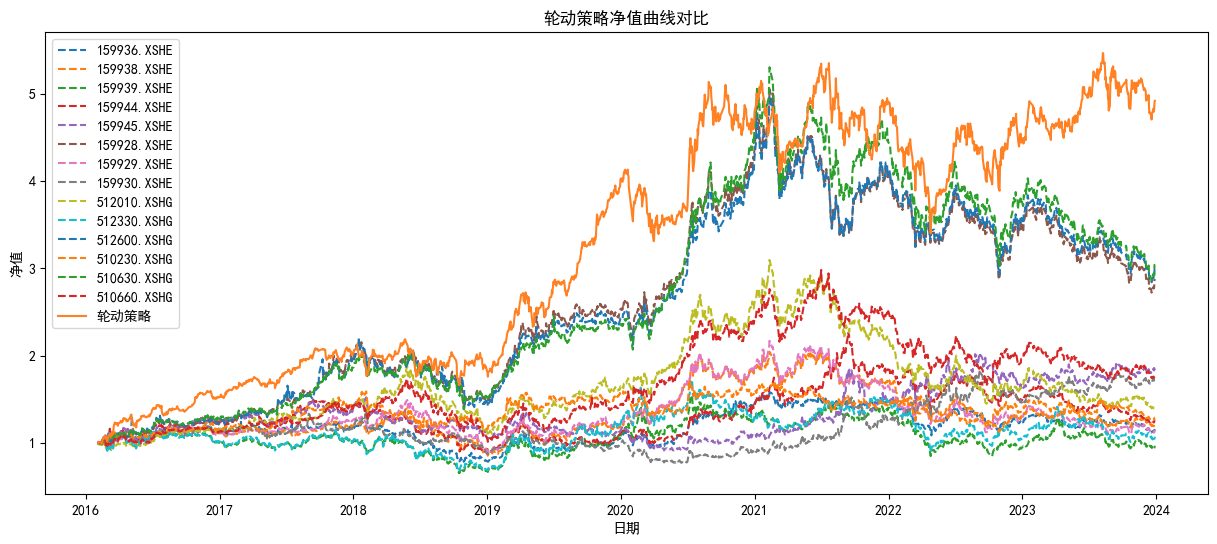

In [158]:
# 可选的ETF 时间长的ETf少

import matplotlib.pyplot as plt
# 显示中文设置
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

# 绘制净值曲线图
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('日期')
ax.set_ylabel('净值')
for name in name_list+['轮动策略']:
    if name in name_list:
        data[name+'净值'] = data[name]/data[name].iloc[0]
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='--')
    else:
        ax.plot(data[name+'净值'].index, data[name+'净值'].values, linestyle='-', color='#FF8124')

# 显示图例和标题
ax.legend(name_list+['轮动策略'])
ax.set_title('轮动策略净值曲线对比')

plt.show()

In [128]:
b = data['轮动策略净值'].values
len(b)

1923

In [144]:
len(a)

1923

In [145]:
np.corrcoef(a,b)

array([[1.        , 0.87954228],
       [0.87954228, 1.        ]])

                    Strategy
------------------  ----------
Start Period        2016-02-03
End Period          2023-12-29
Risk-Free Rate      0.0%
Time in Market      96.0%

Cumulative Return   393.37%
CAGR﹪              14.95%

Sharpe              0.97
Prob. Sharpe Ratio  99.6%
Sortino             1.43
Sortino/√2          1.01
Omega               1.19

Max Drawdown        -36.44%
Longest DD Days     742

Gain/Pain Ratio     0.19
Gain/Pain (1M)      1.12

Payoff Ratio        1.06
Profit Factor       1.19
Common Sense Ratio  1.41
CPC Index           0.67
Tail Ratio          1.18
Outlier Win Ratio   4.06
Outlier Loss Ratio  3.56

MTD                 -2.69%
3M                  -2.88%
6M                  -0.68%
YTD                 10.66%
1Y                  8.7%
3Y (ann.)           0.52%
5Y (ann.)           14.35%
10Y (ann.)          14.95%
All-time (ann.)     14.95%

Avg. Drawdown       -3.66%
Avg. Drawdown Days  30
Recovery Factor     5.03
Ulcer Index         0.11
Serenity Index      1.3

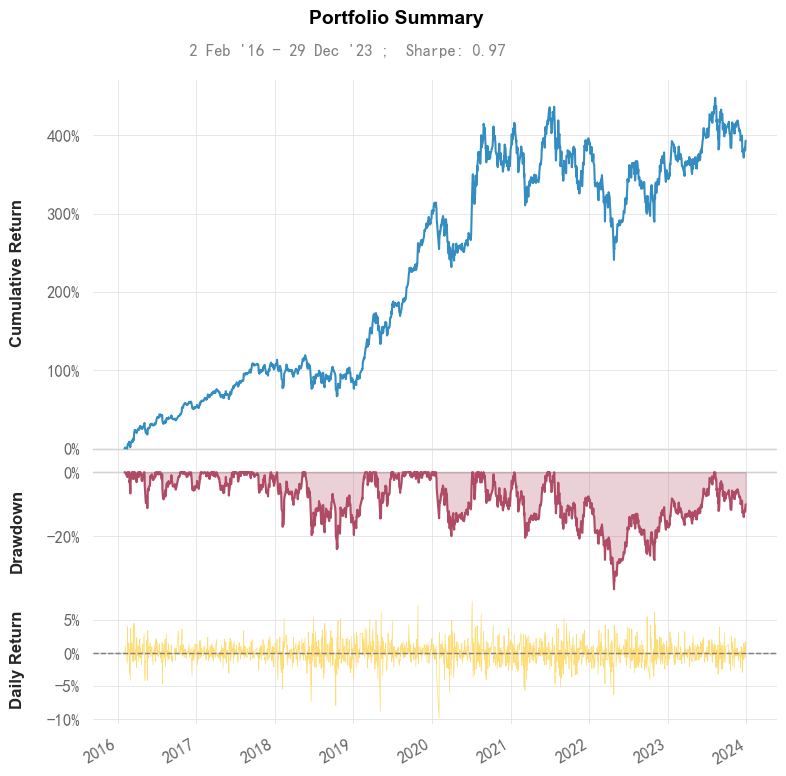

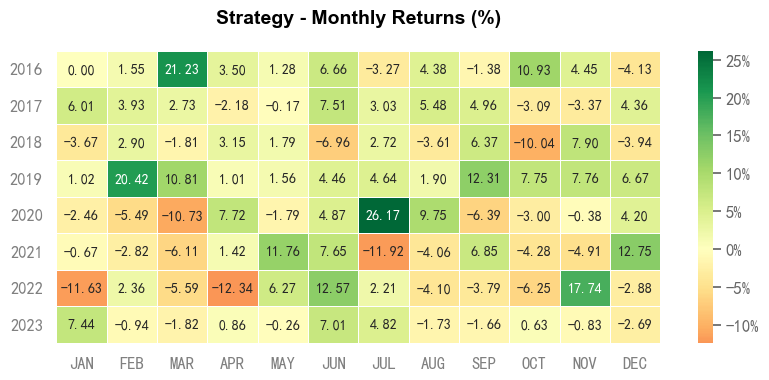

In [141]:
import quantstats as qstat

#将完整回测报告存为HTML文件
qstat.reports.html(data['轮动策略净值'],
                  title='轮动策略回测报告',
                  download_filename='轮动策略回测报告.html') 
#输出基本回测报告信息
qstat.reports.basic(data['轮动策略净值']) 

# 感觉单纯的反转/动量 自适应性不好，因子失效风格转换后 回撤较大

因子合成

In [55]:
data = data_2.copy()
name_list = data.columns.values.tolist()
N = 20
n = 5
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['长涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
    data['短涨幅_'+name] = data[name] / data[name].shift(n+1) - 1.0
    data[name] = data['长涨幅_'+name]-data['短涨幅_'+name]
data_factor = data[[v for v in name_list]]
factor = pd.DataFrame(data_factor.stack())[0]
print(factor)

date        order_book_id
2016-02-02  159936.XSHE     -0.181589
            159938.XSHE     -0.122135
            159939.XSHE     -0.131648
            159944.XSHE     -0.103034
            159945.XSHE     -0.073270
                               ...   
2023-12-29  512330.XSHG     -0.031293
            512600.XSHG     -0.081992
            510230.XSHG     -0.034931
            510630.XSHG     -0.085305
            510660.XSHG     -0.069436
Name: 0, Length: 26936, dtype: float64


In [56]:
prices

order_book_id,159936.XSHE,159938.XSHE,159939.XSHE,159944.XSHE,159945.XSHE,159928.XSHE,159929.XSHE,159930.XSHE,512010.XSHG,512330.XSHG,512600.XSHG,510230.XSHG,510630.XSHG,510660.XSHG
date,,,,,,,,,,,,,,
2016-02-02,1.330,0.5585,0.5330,0.686,0.555,0.2950,1.242,0.721,0.2790,0.785,0.2426,0.7241,0.3135,1.309
2016-02-03,1.355,0.5730,0.5425,0.689,0.562,0.2980,1.267,0.723,0.2875,0.799,0.2440,0.7329,0.3173,1.331
2016-02-04,1.336,0.5700,0.5355,0.691,0.565,0.2990,1.265,0.731,0.2825,0.794,0.2440,0.7300,0.3165,1.329
2016-02-05,1.340,0.5725,0.5355,0.699,0.565,0.2945,1.262,0.720,0.2800,0.790,0.2416,0.7218,0.3150,1.334
2016-02-15,1.382,0.5940,0.5595,0.708,0.576,0.2998,1.346,0.749,0.2832,0.825,0.2474,0.7411,0.3235,1.376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.527,0.6810,0.5010,0.850,1.028,0.8250,1.414,1.238,0.4010,0.813,0.7020,0.9250,0.9260,2.328
2023-12-26,1.532,0.6870,0.5050,0.852,1.044,0.8300,1.418,1.260,0.4030,0.824,0.7070,0.9270,0.9310,2.334
2023-12-27,1.553,0.6930,0.5160,0.871,1.033,0.8550,1.439,1.245,0.4100,0.838,0.7280,0.9440,0.9640,2.359


* 改进轮动方式
* 广发基金思路：广发基金旗下的10个行业（主题）指数基金对应的标的指数、债券指数为回测基础。

策略调仓周期为1周，每周五用模型对该10个行业（主题）指数量、价走势进行判断，从中选出满足条件的2个最优行业指数基金，并按照模型计算的比例进行配置；若模型判断市场处于弱势格局，则相应调减权益类基金的仓位，增加低风险的债券与货币基金的仓位。

In [108]:
df_bond_etf = pd.read_excel('ETF_bond.xlsx')
bond_etf_code = df_bond_etf.code.values.tolist()
bond_etf_code = [id_convert(code) for code in bond_etf_code]
df_price_bond = get_price(bond_etf_code,start_date='20160101',end_date='20231231',fields='close')

In [109]:
data_bond = df_price_bond.copy()
data_bond = data_bond.unstack(level = 0)
data_bond.columns = data_bond.columns.droplevel(0)
data_bond = data_bond.dropna(axis=1 , how='any')
data_bond

order_book_id,159001.XSHE,159003.XSHE,159005.XSHE,511800.XSHG,511810.XSHG,511830.XSHG,511860.XSHG,511880.XSHG,511900.XSHG,511930.XSHG,511980.XSHG,511990.XSHG,511010.XSHG,511220.XSHG
date,,,,,,,,,,,,,,
2016-01-04,99.992,99.987,99.990,99.968,99.974,99.972,99.970,82.3373,99.979,99.978,99.960,99.975,109.505,7.2353
2016-01-05,99.999,99.999,100.002,99.976,99.981,99.980,99.978,82.3768,99.977,100.000,99.976,99.994,109.440,7.2346
2016-01-06,100.001,100.002,100.002,99.997,99.996,100.000,99.994,82.3842,99.995,99.995,99.992,100.006,109.475,7.2353
2016-01-07,100.000,99.999,100.000,100.000,99.998,100.000,99.998,82.3907,99.999,100.001,99.998,100.010,109.591,7.2349
2016-01-08,100.001,100.000,100.005,100.007,100.005,100.005,100.003,82.4121,100.004,100.008,100.003,100.024,109.850,7.2699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,100.000,99.997,99.999,99.996,99.997,99.992,99.998,100.0398,100.000,99.995,100.088,99.988,132.895,10.0460
2023-12-26,100.001,99.997,99.999,99.987,99.997,99.993,99.998,100.0388,99.999,99.995,100.201,99.987,132.997,10.0450
2023-12-27,100.000,99.990,99.999,99.996,99.996,99.994,99.998,100.0418,99.997,99.995,100.054,99.981,133.126,10.0510


In [94]:
def generate_signal(data,N = 20):
    name_list = data.columns.values.tolist()
    for name in name_list:
        data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
        data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
        data = data.dropna()
    data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
    data['信号'] = data['信号'].shift(1)
    data = data.dropna()
    data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
    # 第一天尾盘交易，当日涨幅不纳入
    data.loc[data.index[0],'轮动策略日收益率'] = 0.0
    data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
    return data
data_bond = generate_signal(data_bond)

In [98]:
data_2 = generate_signal(data_2)

In [99]:
merged_df = pd.merge(data_bond,data_2,on='date')
merged_df

order_book_id,159001.XSHE,159003.XSHE,159005.XSHE,511800.XSHG,511810.XSHG,511830.XSHG,511860.XSHG,511880.XSHG,511900.XSHG,511930.XSHG,...,涨幅_512600.XSHG,日收益率_510230.XSHG,涨幅_510230.XSHG,日收益率_510630.XSHG,涨幅_510630.XSHG,日收益率_510660.XSHG,涨幅_510660.XSHG,信号_y,轮动策略日收益率_y,轮动策略净值_y
date,,,,,,,,,,,,,,,,,,,,,
2017-03-22,100.000,99.992,100.001,99.993,99.991,99.994,99.990,84.9707,99.991,99.983,...,0.021053,-0.011867,-0.046373,-0.000682,0.022569,0.009963,0.060131,512330.XSHG,0.000000,1.000000
2017-03-23,99.999,99.998,100.000,99.989,99.994,99.990,99.989,84.9833,99.995,99.989,...,-0.005488,0.004121,-0.041690,0.001138,0.011960,0.011097,0.066320,512010.XSHG,-0.013333,0.986667
2017-03-24,99.995,99.989,100.000,100.000,99.994,100.001,99.999,84.9833,99.998,99.998,...,0.023385,0.006801,-0.031035,-0.000455,0.020891,-0.007317,0.042254,512010.XSHG,0.007883,0.994444
2017-03-27,99.994,99.981,99.996,99.988,99.988,99.996,99.982,84.9993,99.987,99.998,...,0.024661,0.004426,-0.024434,-0.008640,0.014425,-0.001843,0.035692,512010.XSHG,-0.013408,0.981111
2017-03-28,99.994,99.980,99.999,99.986,99.985,99.986,99.979,85.0027,99.978,99.996,...,0.043750,-0.003827,-0.021080,-0.002752,0.020657,-0.004923,0.036538,512010.XSHG,0.000849,0.981944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,100.000,99.997,99.999,99.996,99.997,99.992,99.998,100.0398,100.000,99.995,...,-0.078227,-0.003219,-0.056853,0.009751,-0.076313,0.008617,-0.057189,159930.XSHE,0.012924,0.712127
2023-12-26,100.001,99.997,99.999,99.987,99.997,99.993,99.998,100.0388,99.999,99.995,...,-0.075099,-0.004306,-0.049332,-0.006438,-0.071214,-0.005553,-0.054811,159930.XSHE,-0.012759,0.703041
2023-12-27,100.000,99.990,99.999,99.996,99.996,99.994,99.998,100.0418,99.997,99.995,...,-0.066050,0.002162,-0.043344,0.005400,-0.067134,0.002577,-0.067146,159930.XSHE,0.017771,0.715534


In [101]:
data = merged_df.copy()
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')


data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()

KeyError: '信号_y'

In [103]:
merged_df['信号_y']

date
2017-03-22    512330.XSHG
2017-03-23    512010.XSHG
2017-03-24    512010.XSHG
2017-03-27    512010.XSHG
2017-03-28    512010.XSHG
                 ...     
2023-12-25    159930.XSHE
2023-12-26    159930.XSHE
2023-12-27    159930.XSHE
2023-12-28    159930.XSHE
2023-12-29    159930.XSHE
Name: 信号_y, Length: 1650, dtype: object

In [70]:
def generate_equity(data,N = 20):
    name_list = data.columns.values.tolist()
    for name in name_list:
        data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
        data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
        data = data.dropna()
    
    # 近20日涨幅为负 今日收益率为负，调整为bond_etf 反之为
    data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
    


    data['信号'] = data['信号'].shift(1)
    data = data.dropna()
    data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
    # 第一天尾盘交易，当日涨幅不纳入
    data.loc[data.index[0],'轮动策略日收益率'] = 0.0
    data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
    return data

order_book_id  涨幅_159936.XSHE  涨幅_159938.XSHE  涨幅_159939.XSHE  涨幅_159944.XSHE  \
date                                                                            
2017-03-22           0.025999        0.042220        0.036044       -0.002222   
2017-03-23           0.003125        0.043036        0.033180        0.010000   
2017-03-24           0.031032        0.028527        0.037684       -0.003311   
2017-03-27           0.022013        0.022342        0.025547        0.000000   
2017-03-28           0.022013        0.026316        0.026606        0.002215   
...                       ...             ...             ...             ...   
2023-12-25          -0.054635       -0.060357       -0.046816       -0.045964   
2023-12-26          -0.062039       -0.059392       -0.065299       -0.039548   
2023-12-27          -0.065284       -0.065306       -0.059590       -0.039459   
2023-12-28          -0.044895       -0.049383       -0.039106       -0.014706   
2023-12-29          -0.03094

order_book_id,159936.XSHE,159938.XSHE,159939.XSHE,159944.XSHE,159945.XSHE,159928.XSHE,159929.XSHE,159930.XSHE,512010.XSHG,512330.XSHG,...,涨幅_512600.XSHG,日收益率_510230.XSHG,涨幅_510230.XSHG,日收益率_510630.XSHG,涨幅_510630.XSHG,日收益率_510660.XSHG,涨幅_510660.XSHG,信号,轮动策略日收益率,轮动策略净值
date,,,,,,,,,,,,,,,,,,,,,
2017-03-22,1.618,0.6665,0.5605,0.898,0.733,0.4038,1.461,0.839,0.3600,0.845,...,0.021053,-0.011867,-0.046373,-0.000682,0.022569,0.009963,0.060131,512330.XSHG,0.000000,1.000000
2017-03-23,1.605,0.6665,0.5605,0.909,0.725,0.4067,1.468,0.838,0.3552,0.845,...,-0.005488,0.004121,-0.041690,0.001138,0.011960,0.011097,0.066320,512010.XSHG,-0.013333,0.986667
2017-03-24,1.628,0.6670,0.5645,0.903,0.731,0.4088,1.468,0.835,0.3580,0.857,...,0.023385,0.006801,-0.031035,-0.000455,0.020891,-0.007317,0.042254,512010.XSHG,0.007883,0.994444
2017-03-27,1.625,0.6635,0.5620,0.905,0.729,0.4120,1.467,0.829,0.3532,0.852,...,0.024661,0.004426,-0.024434,-0.008640,0.014425,-0.001843,0.035692,512010.XSHG,-0.013408,0.981111
2017-03-28,1.625,0.6630,0.5595,0.905,0.729,0.4125,1.458,0.836,0.3535,0.845,...,0.043750,-0.003827,-0.021080,-0.002752,0.020657,-0.004923,0.036538,512010.XSHG,0.000849,0.981944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.540,0.6850,0.5090,0.851,1.038,0.8300,1.424,1.254,0.4040,0.831,...,-0.078227,-0.003219,-0.056853,0.009751,-0.076313,0.008617,-0.057189,159930.XSHE,0.012924,0.712127
2023-12-26,1.527,0.6810,0.5010,0.850,1.028,0.8250,1.414,1.238,0.4010,0.813,...,-0.075099,-0.004306,-0.049332,-0.006438,-0.071214,-0.005553,-0.054811,159930.XSHE,-0.012759,0.703041
2023-12-27,1.532,0.6870,0.5050,0.852,1.044,0.8300,1.418,1.260,0.4030,0.824,...,-0.066050,0.002162,-0.043344,0.005400,-0.067134,0.002577,-0.067146,159930.XSHE,0.017771,0.715534


In [74]:
data_2

order_book_id,159936.XSHE,159938.XSHE,159939.XSHE,159944.XSHE,159945.XSHE,159928.XSHE,159929.XSHE,159930.XSHE,512010.XSHG,512330.XSHG,512600.XSHG,510230.XSHG,510630.XSHG,510660.XSHG
date,,,,,,,,,,,,,,
2016-01-04,1.779,0.6840,0.6590,0.854,0.670,0.3520,1.496,0.912,0.3248,0.964,0.2854,0.8410,0.3645,1.564
2016-01-05,1.638,0.6700,0.6445,0.815,0.669,0.3475,1.464,0.890,0.3232,0.929,0.2728,0.8460,0.3660,1.555
2016-01-06,1.649,0.6715,0.6490,0.855,0.689,0.3500,1.485,0.899,0.3248,0.951,0.2822,0.8536,0.3705,1.577
2016-01-07,1.590,0.6335,0.5845,0.810,0.643,0.3465,1.404,0.899,0.3150,0.880,0.2814,0.8130,0.3558,1.488
2016-01-08,1.604,0.6405,0.5950,0.824,0.665,0.3302,1.408,0.865,0.3200,0.878,0.2692,0.8216,0.3520,1.480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.540,0.6850,0.5090,0.851,1.038,0.8300,1.424,1.254,0.4040,0.831,0.7070,0.9290,0.9320,2.341
2023-12-26,1.527,0.6810,0.5010,0.850,1.028,0.8250,1.414,1.238,0.4010,0.813,0.7020,0.9250,0.9260,2.328
2023-12-27,1.532,0.6870,0.5050,0.852,1.044,0.8300,1.418,1.260,0.4030,0.824,0.7070,0.9270,0.9310,2.334


In [ ]:
name_list = data.columns.values.tolist()
for name in name_list:
    data['日收益率_'+name] = data[name] / data[name].shift(1) - 1.0
    data['涨幅_'+name] = data[name] / data[name].shift(N+1) - 1.0
    data = data.dropna()
data['信号'] = data[['涨幅_'+v for v in name_list]].idxmax(axis=1).str.replace('涨幅_', '')
data['信号'] = data['信号'].shift(1)
data = data.dropna()
data['轮动策略日收益率'] = data.apply(lambda x: x['日收益率_'+x['信号']], axis=1) 
# 第一天尾盘交易，当日涨幅不纳入
data.loc[data.index[0],'轮动策略日收益率'] = 0.0
data['轮动策略净值'] = (1.0 + data['轮动策略日收益率']).cumprod()
return data

* 根据一定标准更新的动态股票池，其更新标准应该是：一直保持无交集且高度差异化的少数几只etf，且这几只etf的并集又可以代表市场上绝大多数风格。

In [76]:
def get_matrix(index_list, start_dt, end_dt):
    total_close_list = []
    df = get_price(index_list, start_dt, end_dt, fields='close')
    df = df.unstack(level = 0)
    df.columns = df.columns.droplevel(0)
    df = df.dropna(axis=1 , how='any')
    for index in df.columns.values.tolist():
        close_list = df[index].values
        total_close_list.append(close_list)
    matrix = np.corrcoef(total_close_list)
    print(matrix)
get_matrix(etf_code_3 , start_dt='20160101',end_dt='20231231')

[[ 1.          0.82618931  0.77026511  0.87372739  0.37298887  0.73802299
   0.76051862  0.30454069  0.71019773  0.69157141  0.74890916  0.43130817
   0.77537192  0.82394473]
 [ 0.82618931  1.          0.82410946  0.66851827  0.05530805  0.86383881
   0.98075679 -0.05044488  0.96280513  0.8016884   0.8458775   0.63554685
   0.86570104  0.94476364]
 [ 0.77026511  0.82410946  1.          0.57027629 -0.06582718  0.6019611
   0.79251001 -0.11701539  0.7129325   0.95576386  0.58221829  0.50315554
   0.60837065  0.70708192]
 [ 0.87372739  0.66851827  0.57027629  1.          0.61669561  0.67282019
   0.58058672  0.52001754  0.56792592  0.53276299  0.69974189  0.29040637
   0.72950021  0.76302951]
 [ 0.37298887  0.05530805 -0.06582718  0.61669561  1.          0.3444681
  -0.08903558  0.97855942 -0.02946694  0.02346257  0.40282524 -0.06404988
   0.39709637  0.30998978]
 [ 0.73802299  0.86383881  0.6019611   0.67282019  0.3444681   1.
   0.79702369  0.23483767  0.87031861  0.6759237   0.99711561